# Set up

In [115]:
## prepare packages
#%pip install -U pandas
#%pip install -U matplotlib
#%pip install -U gensim
#%pip install -U scipy
#%pip install -U pyLDAvis
#%pip install -U plotly
#%pip install -U 'nbformat>=4.2.0'

In [116]:
## import modules
import os, sys
## maake accessible files on level immediately above 
sys.path.append(os.path.join(os.path.dirname("__file__"), ".."))
## import other modules
import re
import gzip, glob
import unicodedata

# Preparation 1

In [117]:
## parameters
verbose              = True
save_results         = False
targets_csv          = True

## source sampling
source_sampling      = True
source_sampling_rate = 0.03 # optimal values depend on kinds of source

## doc settings # The longer sentences become, the less precise pairing becomes
size_measures        = [ 'sp_size', 'sn_size' ]
size_measure         = size_measures[1]
max_doc_size         = 10 # values larger than 10 take considerably longer to complete
min_doc_size         =  4

## preprocessing settings
lower_chars          = True
strip_accents        = True
add_boundaries       = True
boundary_symbol      = '#'  # requires more processing resource
if add_boundaries:
    hash_status = "-hashed"
else:
    hash_status = ""

## term settings
ngram_is_inclusive    = True # takes significantly more time to complete but invites sum error if False with larger n, 
inclusion_degree      = 1    # Valid values are {0, 1, 2, ..., None}. With k, n-grams includes (n-k)-grams
max_gap_size_factor   = 0.53 # It takes time at valuers larger than 0.5 with larger n such as n = 5
max_gap_size          = round(max_doc_size * max_gap_size_factor) # This needs to be smaller than other cases.

## Skippy n-gram の隙間を表わす記号
gap_marker            = "…"

## spell term と sound term の連結記号
pair_marker           = " :: "

## set spell term_type
sp_term_types  = [ 'sp_1gram',
                  'sp_2gram', 'sp_3gram', 'sp_4gram', 'sp_5gram',
                 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
sp_term_type   = sp_term_types[3]
print(f"sp_term_type: {sp_term_type}")

## set sound term_type
sn_term_types = [ 'sn_1gram',
                 'sn_2gram', 'sn_3gram', 'sn_4gram', 'sn_5gram',
                 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
sn_term_type = sn_term_types[3]
print(f"sn_term_type: {sn_term_type}")

sp_term_type: sp_4gram
sn_term_type: sn_4gram


In [118]:
## term filtering: some combinations cause "Not all rows sum to 1" error with HDP, but no with LDA
apply_term_freq_filtering  = True
term_minfreq               = 3 # Effective for speeding up
apply_term_abuse_filtering = True
term_abuse_threshold       = 0.1 # Larger values reveal deeper; 0.006 seems to be the smallest

In [119]:
## select HDP or LDA: HDP takes considerably longer than LDA,
## and is susceptible with "Not all rows sum to 1" error at pyLDAvis
## HDP
use_HDP         = True
max_n_topics    = 45
n_terms_to_show = 120

## LDA
n_topics  = max_n_topics # 精度にはあまり影響しない？
if use_HDP:
    method_name  = "HDP" # non-executive variable to be used in file names
else:
    method_name  = "LDA"

## tSNE
top_perplexity_reduct_rate = 0.33
##
print(f"method_name: {method_name}")
print(f"max_n_topics for HDP: {max_n_topics}")
print(f"n_topics for LDA: {n_topics}")
print(f"top_perplexity_reduct_rate: {top_perplexity_reduct_rate}")

method_name: HDP
max_n_topics for HDP: 45
n_topics for LDA: 45
top_perplexity_reduct_rate: 0.33


In [120]:
## get data
import glob
data_dir1 = "data/open-dict-ipa/data1"
data_dir2 = "data/open-dict-ipa/data1a"
files = [ ]
for dir in [ data_dir1, data_dir2 ]:
    gz_files = glob.glob(f"{dir}/*.gz")
    files.extend(gz_files)
    csv_files = glob.glob(f"{dir}/*.csv")
    files.extend(csv_files)
    txt_files = glob.glob(f"{data_dir2}/*.txt")
    files.extend(txt_files)
#
files

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/vi_N.csv.gz',
 'data/open-dict-ipa/data1/j

In [121]:
## select language and file
lang_names = {  'ar' : 'Arabic',  # 0
                'de' : 'German',  # 1
                'en' : 'English', # 2
                'es' : 'Spanish', # 3
                'fr' : 'French',  # 4
                'sw' : 'Swahili'  # 5
            }
#
lang_keys = [ 'ar', 'de', 'en', 'es', 'fr', 'sw' ]
#
lang_key  = lang_keys[4]
lang_name = lang_names[lang_key]
lang_attr = ""
print(f"lang_name: {lang_name} ({lang_attr}) [lang_key: {lang_key}]")
# aliases
target_lang_dict = lang_names
target_lang_keys = lang_keys
target_lang_key  = lang_key
target_lang_attr = lang_attr
#
files = [ file for file in files if f"/{lang_key}" in file ]
print(files)
if len(lang_attr) > 0:
    print(f"lang_attr: {lang_attr}")
    selected_files = [ file for file in files if lang_attr in file ]
else:
    selected_files = files
selected_files
if len(selected_files) == 0:
    exit()

lang_name: French () [lang_key: fr]
['data/open-dict-ipa/data1/fr_QC.csv.gz', 'data/open-dict-ipa/data1/fr_FR.csv.gz']


In [122]:
## build data from files
import re, unicodedata
import pandas as pd
check = False
target_file = selected_files[0]
col_names = [ 'sp_word', 'sn_word' ]
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
#
raw_df

,sp_word,sn_word
0,a,/a/
1,A,/a/
2,à,/a/
3,à aucun moment,/aokœ̃˞mɑɔ̯mæ̃/
4,à aucun prix,/aokœ̃˞pʁi/
...,...,...
245953,zyeutons,/zjøtõũ̯/
245954,zygomatique,/zɪgɑɔ̯mat͡sɪk/
245955,zygomatiques,/zɪgɑɔ̯mat͡sɪk/
245956,zygote,/zɪgɑɔ̯t/


In [123]:
## modify spell
raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
if lower_chars:
    raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: x.lower())

## modify sound symbols
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"/", "", x))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: x.split(",")[0]) # pick up only the first
if strip_accents:
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r'"', "", x))
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"[ˈˌ]", "", x))
#
raw_df

,sp_word,sn_word
0,a,a
1,a,a
2,à,a
3,à aucun moment,aokœ̃˞mɑɔ̯mæ̃
4,à aucun prix,aokœ̃˞pʁi
...,...,...
245953,zyeutons,zjøtõũ̯
245954,zygomatique,zɪgɑɔ̯mat͡sɪk
245955,zygomatiques,zɪgɑɔ̯mat͡sɪk
245956,zygote,zɪgɑɔ̯t


In [124]:
## build df
dids = [ ]
sids = [ ]
Spells = [ ]
Sounds = [ ]
for i, row in raw_df.iterrows():
    spell = row['sp_word']
    sound = row['sn_word']
    if len(spell) > 0 and len(sound) > 0:
        dids.append(i + 1)
        sids.append(i + 1)
        Spells.append(spell)
        Sounds.append(sound)
#
var_names = [ 'did', 'sid', 'sp_word', 'sn_word',
            'sp_size', 'sn_size', 'paired_terms', 
            'sp_1gram', 'sp_2gram', 'sp_3gram',
            'sp_sk2gram', 'sp_sk3gram',
            'sn_1gram', 'sn_2gram', 'sn_3gram', 
            'sn_sk2gram', 'sn_sk3gram' ]
df = pd.DataFrame()
df['did'] = dids
df['sid'] = sids
df['sp_word'] = Spells
df['sn_word'] = Sounds
#
df[var_names[:4]]

,did,sid,sp_word,sn_word
0,1,1,a,a
1,2,2,a,a
2,3,3,à,a
3,4,4,à aucun moment,aokœ̃˞mɑɔ̯mæ̃
4,5,5,à aucun prix,aokœ̃˞pʁi
...,...,...,...,...
245953,245954,245954,zyeutons,zjøtõũ̯
245954,245955,245955,zygomatique,zɪgɑɔ̯mat͡sɪk
245955,245956,245956,zygomatiques,zɪgɑɔ̯mat͡sɪk
245956,245957,245957,zygote,zɪgɑɔ̯t


In [125]:
## sampling
if source_sampling:
    original_size = len(df)
    sample_size = round(len(df) * source_sampling_rate)
    df = df.sample(sample_size)
    print(f"sampled {len(df)} ({source_sampling_rate:0.3f}) rows by discarding {original_size - len(df)} rows")

sampled 7379 (0.030) rows by discarding 238579 rows


In [126]:
## tokenization
import gzip, re
import pandas as pd
check = False
Snx = [ ]
Spx = [ ]
for i, row in df.iterrows():
    Spt = row['sp_word']
    Snt = row['sn_word']
    split_pattern = r""
    ## Spell
    sp_seg = [ x for x in re.split(split_pattern, Spt) if len(x) > 0 ]
    if check:
        print(sp_seg)
    Spx.append(sp_seg)
    ## Sound
    sn_seg = [ x for x in re.split(split_pattern, Snt) if len(x) > 0 ]
    if check:
        print(sn_seg)
    Snx.append(sn_seg)
## Spell
try:
    df['sp_1gram'] = Spx
except ValueError:
    pass
## Sound
try:
    df['sn_1gram'] = Snx
except ValueError:
    pass
## check result
if verbose:
    df

In [127]:
## add size columns
df['sp_size'] = df['sp_1gram'].apply(lambda x: len(x))
df['sn_size'] = df['sn_1gram'].apply(lambda x: len(x))
if verbose:
    df

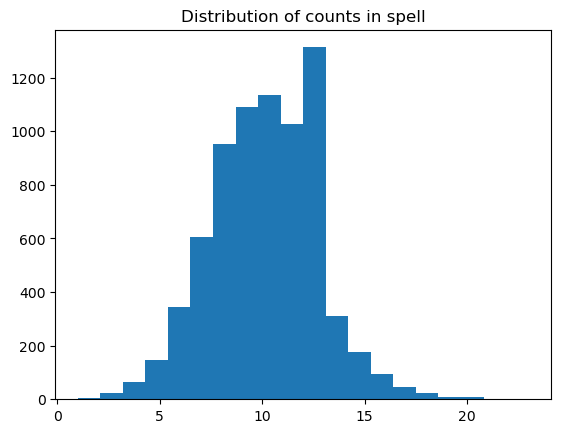

In [128]:
## 語の綴り文字数の分布
import matplotlib.pyplot as plt
plt.hist(df['sp_size'], bins = 20)
plt.title(f"Distribution of counts in spell")
plt.show()

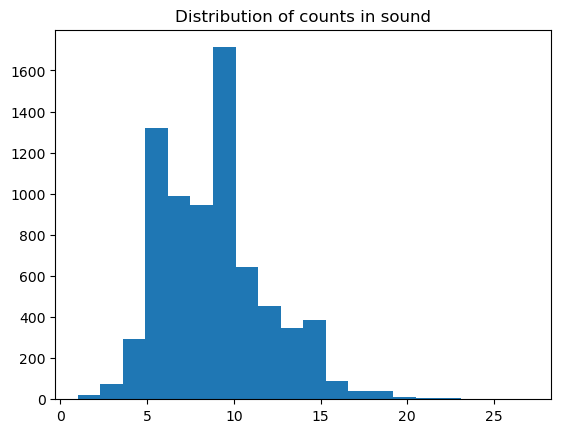

In [129]:
## 語の発音記号数の分布
import matplotlib.pyplot as plt
plt.hist(df['sn_size'], bins = 20)
plt.title(f"Distribution of counts in sound")
plt.show()

# build terms, part 1

In [130]:
## 長さで濾過
original_size = len(df)
print(f"discarding pairs whose {size_measure} part has less than {min_doc_size} chars")
df = df[df[size_measure] >= min_doc_size]

print(f"discarding pairs whose {size_measure} part has more than {max_doc_size} chars")
df = df[df[size_measure] < max_doc_size]

current_size = len(df)
size_diff = original_size - current_size
print(f"{size_diff} ({size_diff/original_size:.3f}) pairs were removed")
print(f"{current_size} pairs remain")

discarding pairs whose sn_size part has less than 4 chars
discarding pairs whose sn_size part has more than 10 chars
2895 (0.392) pairs were removed
4484 pairs remain


In [131]:
## add boundaries
if add_boundaries:
    df['sp_word'] = df['sp_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df['sn_word'] = df['sn_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df[['sp_word', 'sn_word']]

In [132]:
## add 1gram
import re
w_splitter = r""
df['sp_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sp_word'] ]
df['sn_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sn_word'] ]
df[['sp_1gram', 'sn_1gram']]

,sp_1gram,sn_1gram
51481,"[#, c, o, n, t, r, ô, l, e, r, #]","[#, k, õ, ũ, ̯, t, ʁ, o, l, e, #]"
214755,"[#, s, é, c, r, é, t, é, s, #]","[#, s, e, k, ʁ, e, t, e, #]"
41129,"[#, c, i, r, c, u, l, a, i, #]","[#, s, ɪ, ʁ, k, ʏ, l, a, #]"
93809,"[#, e, n, c, h, é, r, i, r, a, #]","[#, ɑ, ̃, ʃ, e, ʁ, ɪ, ʁ, ɔ, #]"
12575,"[#, a, p, p, e, l, #]","[#, a, p, a, l, #]"
...,...,...
94800,"[#, e, n, d, o, r, m, i, e, s, #]","[#, ɑ, ̃, d, ɑ, ɔ, ̯, ʁ, m, i, #]"
157646,"[#, m, u, t, a, s, s, e, s, #]","[#, m, ʏ, t, a, s, #]"
228181,"[#, t, a, i, l, l, e, r, i, o, n, s, #]","[#, t, a, j, ə, ʁ, j, õ, ũ, ̯, #]"
60674,"[#, d, é, c, a, p, s, u, l, e, z, #]","[#, d, e, k, a, p, s, ʏ, l, e, #]"


In [133]:
## inspect frequent tokens in sp_1gram
from collections import Counter
sp_chars_all = [ ] 
[ sp_chars_all.extend(list(x)) for x in df['sp_1gram'] ]
sp_char_freqs = Counter(sp_chars_all)
## Show most frequent 10 segments
sｐ_char_freqs.most_common(10)

[('#', 8968),
 ('e', 4653),
 ('s', 4083),
 ('a', 3918),
 ('r', 3363),
 ('i', 3306),
 ('t', 2733),
 ('n', 2529),
 ('u', 1671),
 ('o', 1613)]

In [134]:
## inspect frequent tokens in sn_1gram
from collections import Counter
sn_chars_all = [ ] 
[ sn_chars_all.extend(list(x)) for x in df['sn_1gram'] ]
sn_char_freqs = Counter(sn_chars_all)
## Show most frequent 10 segments
sn_char_freqs.most_common(10)

[('#', 8968),
 ('a', 4051),
 ('ʁ', 3127),
 ('e', 2168),
 ('s', 1761),
 ('t', 1477),
 ('ɪ', 1281),
 ('l', 1153),
 ('̯', 1141),
 ('ɑ', 1090)]

In [135]:
## Install nltk if necessary
#!pip install -U nltk

n-grams の構築

In [136]:
def gen_ngrams_from_str(t: str, n: int, sep: str = r"", joint: str = "", check = False):
    'returns the list of character n-grams from a given string'
    import re
    segs = [ x for x in re.split(sep, t) if len(x) > 0 ]
    if check:
        print(segs)
    ## short input
    if len(segs) <= n:
        return segs
    ## long enough input
    G = [ ]
    for i in range(len(segs)):
        try:
            b = segs[ i : i + n ]
            if check:
                print(b)
            c = joint.join(b)
            if check:
                print(c)
            if len(c) == n:
                G.append(c)
        except IndexError:
            pass
    return G

In [137]:
## generic n-gram generation function
def add_ngrams(dfx, n_for_ngram: int, prefix: str = "", skippy: bool = False, skippiness_symbol: str = "sk", max_distance = None, seg_joint: str = "", gap_mark: str = "…", inclusive: bool = True, inclusion_degree = None, check: bool = False):
    "add ngram col to the dfx given"
    import gen_ngrams
    ## set variable names
    source_var_name = f"{prefix}1gram"
    if skippy:
        target_var_name  = f"{prefix}{skippiness_symbol}{n_for_ngram}gram"
        if n_for_ngram == 2:
            sub_var_name = f"{prefix}{n_for_ngram - 1}gram"
        else:
            sub_var_name = f"{prefix}{skippiness_symbol}{n_for_ngram - 1}gram"
            
    else:
        target_var_name  = f"{prefix}{n_for_ngram}gram"
        sub_var_name     = f"{prefix}{n_for_ngram - 1}gram"
    if check:
        print(f"source_var_name: {source_var_name}")
        print(f"target_var_name: {target_var_name}")
        print(f"sub_var_name: {sub_var_name}")
        
    ## 1gram
    unigrams = dfx[source_var_name]
    
    ## ngram
    if skippy:
        ngrams = [ gen_ngrams.gen_skippy_ngrams(g, n = n_for_ngram, sep = seg_joint, missing_mark = gap_mark, max_distance = max_distance, check = check) for g in unigrams ]
    else:
        ngrams = [ gen_ngrams.gen_ngrams(g, n = n_for_ngram, sep = seg_joint, check = check) for g in unigrams ]
    
    ## make ngrams inclusive
    if inclusive:
        sub_ngrams = list(dfx[sub_var_name])
        if inclusion_degree is None:
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) > 0 ]
                if len(supplement) > 0:
                    gram.extend(supplement)
        else:
            min_size = (n_for_ngram - inclusion_degree)
            assert min_size >= 0
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) >= min_size ]
                if len(supplement) > 0:
                    gram.extend(supplement)
    ## update df
    dfx[target_var_name] = ngrams
    print(dfx[target_var_name])

# Spell n-grams 生成

In [138]:
## sp_2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51481     [#c, co, on, nt, tr, rô, ôl, le, er, r#, #, c,...
214755    [#s, sé, éc, cr, ré, ét, té, és, s#, #, s, é, ...
41129     [#c, ci, ir, rc, cu, ul, la, ai, i#, #, c, i, ...
93809     [#e, en, nc, ch, hé, ér, ri, ir, ra, a#, #, e,...
12575         [#a, ap, pp, pe, el, l#, #, a, p, p, e, l, #]
                                ...                        
94800     [#e, en, nd, do, or, rm, mi, ie, es, s#, #, e,...
157646    [#m, mu, ut, ta, as, ss, se, es, s#, #, m, u, ...
228181    [#t, ta, ai, il, ll, le, er, ri, io, on, ns, s...
60674     [#d, dé, éc, ca, ap, ps, su, ul, le, ez, z#, #...
116037    [#f, fr, ra, ai, is, so, on, ns, s#, #, f, r, ...
Name: sp_2gram, Length: 4484, dtype: object


In [139]:
## sp_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51481     [#co, con, ont, ntr, trô, rôl, ôle, ler, er#, ...
214755    [#sé, séc, écr, cré, rét, été, tés, és#, #s, s...
41129     [#ci, cir, irc, rcu, cul, ula, lai, ai#, #c, c...
93809     [#en, enc, nch, ché, hér, éri, rir, ira, ra#, ...
12575     [#ap, app, ppe, pel, el#, #a, ap, pp, pe, el, l#]
                                ...                        
94800     [#en, end, ndo, dor, orm, rmi, mie, ies, es#, ...
157646    [#mu, mut, uta, tas, ass, sse, ses, es#, #m, m...
228181    [#ta, tai, ail, ill, lle, ler, eri, rio, ion, ...
60674     [#dé, déc, éca, cap, aps, psu, sul, ule, lez, ...
116037    [#fr, fra, rai, ais, iso, son, ons, ns#, #f, f...
Name: sp_3gram, Length: 4484, dtype: object


In [140]:
## sp_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51481     [#con, cont, ontr, ntrô, trôl, rôle, ôler, ler...
214755    [#séc, sécr, écré, crét, rété, étés, tés#, #sé...
41129     [#cir, circ, ircu, rcul, cula, ulai, lai#, #ci...
93809     [#enc, ench, nché, chér, héri, érir, rira, ira...
12575     [#app, appe, ppel, pel#, #ap, app, ppe, pel, el#]
                                ...                        
94800     [#end, endo, ndor, dorm, ormi, rmie, mies, ies...
157646    [#mut, muta, utas, tass, asse, sses, ses#, #mu...
228181    [#tai, tail, aill, ille, ller, leri, erio, rio...
60674     [#déc, déca, écap, caps, apsu, psul, sule, ule...
116037    [#fra, frai, rais, aiso, ison, sons, ons#, #fr...
Name: sp_4gram, Length: 4484, dtype: object


In [141]:
## sp_5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [142]:
## sp_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51481     [#c, #…o, #…n, #…t, co, c…n, c…t, on, o…t, nt,...
214755    [#s, #…é, #…c, #…r, sé, s…c, s…r, éc, é…r, cr,...
41129     [#c, #…i, #…r, #…c, ci, c…r, c…c, ir, i…c, rc,...
93809     [#e, #…n, #…c, #…h, en, e…c, e…h, nc, n…h, ch,...
12575     [#a, #…p, #…p, #…e, ap, a…p, a…e, pp, p…e, pe,...
                                ...                        
94800     [#e, #…n, #…d, #…o, en, e…d, e…o, nd, n…o, do,...
157646    [#m, #…u, #…t, #…a, mu, m…t, m…a, ut, u…a, ta,...
228181    [#t, #…a, #…i, #…l, ta, t…i, t…l, ai, a…l, il,...
60674     [#d, #…é, #…c, #…a, dé, d…c, d…a, éc, é…a, ca,...
116037    [#f, #…r, #…a, #…i, fr, f…a, f…i, ra, r…i, ai,...
Name: sp_sk2gram, Length: 4484, dtype: object


In [143]:
## sp_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51481     [#co, #c…n, #c…t, #…on, #…o…t, #…nt, con, co…t...
214755    [#sé, #s…c, #s…r, #…éc, #…é…r, #…cr, séc, sé…r...
41129     [#ci, #c…r, #c…c, #…ir, #…i…c, #…rc, cir, ci…c...
93809     [#en, #e…c, #e…h, #…nc, #…n…h, #…ch, enc, en…h...
12575     [#ap, #a…p, #a…e, #…pp, #…p…e, #…pe, app, ap…e...
                                ...                        
94800     [#en, #e…d, #e…o, #…nd, #…n…o, #…do, end, en…o...
157646    [#mu, #m…t, #m…a, #…ut, #…u…a, #…ta, mut, mu…a...
228181    [#ta, #t…i, #t…l, #…ai, #…a…l, #…il, tai, ta…l...
60674     [#dé, #d…c, #d…a, #…éc, #…é…a, #…ca, déc, dé…a...
116037    [#fr, #f…a, #f…i, #…ra, #…r…i, #…ai, fra, fr…i...
Name: sp_sk3gram, Length: 4484, dtype: object


In [144]:
## sp_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51481     [#con, #co…t, #c…nt, #…ont, cont, cont, con…r,...
214755    [#séc, #sé…r, #s…cr, #…écr, sécr, sécr, séc…é,...
41129     [#cir, #ci…c, #c…rc, #…irc, circ, circ, cir…u,...
93809     [#enc, #en…h, #e…ch, #…nch, ench, ench, enc…é,...
12575     [#app, #ap…e, #a…pe, #…ppe, appe, appe, app…l,...
                                ...                        
94800     [#end, #en…o, #e…do, #…ndo, endo, endo, end…r,...
157646    [#mut, #mu…a, #m…ta, #…uta, muta, muta, mut…s,...
228181    [#tai, #ta…l, #t…il, #…ail, tail, tail, tai…l,...
60674     [#déc, #dé…a, #d…ca, #…éca, déca, déca, déc…p,...
116037    [#fra, #fr…i, #f…ai, #…rai, frai, frai, fra…s,...
Name: sp_sk4gram, Length: 4484, dtype: object


In [145]:
## sp_sk5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [146]:
## check result
if "5gram" in sp_term_type:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
else:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram' ]
df[var_names]

,sp_word,sp_sk2gram,sp_sk3gram,sp_sk4gram
51481,#contrôler#,"[#c, #…o, #…n, #…t, co, c…n, c…t, on, o…t, nt,...","[#co, #c…n, #c…t, #…on, #…o…t, #…nt, con, co…t...","[#con, #co…t, #c…nt, #…ont, cont, cont, con…r,..."
214755,#sécrétés#,"[#s, #…é, #…c, #…r, sé, s…c, s…r, éc, é…r, cr,...","[#sé, #s…c, #s…r, #…éc, #…é…r, #…cr, séc, sé…r...","[#séc, #sé…r, #s…cr, #…écr, sécr, sécr, séc…é,..."
41129,#circulai#,"[#c, #…i, #…r, #…c, ci, c…r, c…c, ir, i…c, rc,...","[#ci, #c…r, #c…c, #…ir, #…i…c, #…rc, cir, ci…c...","[#cir, #ci…c, #c…rc, #…irc, circ, circ, cir…u,..."
93809,#enchérira#,"[#e, #…n, #…c, #…h, en, e…c, e…h, nc, n…h, ch,...","[#en, #e…c, #e…h, #…nc, #…n…h, #…ch, enc, en…h...","[#enc, #en…h, #e…ch, #…nch, ench, ench, enc…é,..."
12575,#appel#,"[#a, #…p, #…p, #…e, ap, a…p, a…e, pp, p…e, pe,...","[#ap, #a…p, #a…e, #…pp, #…p…e, #…pe, app, ap…e...","[#app, #ap…e, #a…pe, #…ppe, appe, appe, app…l,..."
...,...,...,...,...
94800,#endormies#,"[#e, #…n, #…d, #…o, en, e…d, e…o, nd, n…o, do,...","[#en, #e…d, #e…o, #…nd, #…n…o, #…do, end, en…o...","[#end, #en…o, #e…do, #…ndo, endo, endo, end…r,..."
157646,#mutasses#,"[#m, #…u, #…t, #…a, mu, m…t, m…a, ut, u…a, ta,...","[#mu, #m…t, #m…a, #…ut, #…u…a, #…ta, mut, mu…a...","[#mut, #mu…a, #m…ta, #…uta, muta, muta, mut…s,..."
228181,#taillerions#,"[#t, #…a, #…i, #…l, ta, t…i, t…l, ai, a…l, il,...","[#ta, #t…i, #t…l, #…ai, #…a…l, #…il, tai, ta…l...","[#tai, #ta…l, #t…il, #…ail, tail, tail, tai…l,..."
60674,#décapsulez#,"[#d, #…é, #…c, #…a, dé, d…c, d…a, éc, é…a, ca,...","[#dé, #d…c, #d…a, #…éc, #…é…a, #…ca, déc, dé…a...","[#déc, #dé…a, #d…ca, #…éca, déca, déca, déc…p,..."


# Sound n-grams 生成

In [147]:
## sn_2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51481     [#k, kõ, õũ, ũ̯, ̯t, tʁ, ʁo, ol, le, e#, #, k,...
214755    [#s, se, ek, kʁ, ʁe, et, te, e#, #, s, e, k, ʁ...
41129     [#s, sɪ, ɪʁ, ʁk, kʏ, ʏl, la, a#, #, s, ɪ, ʁ, k...
93809     [#ɑ, ɑ̃, ̃ʃ, ʃe, eʁ, ʁɪ, ɪʁ, ʁɔ, ɔ#, #, ɑ, ̃, ...
12575                [#a, ap, pa, al, l#, #, a, p, a, l, #]
                                ...                        
94800     [#ɑ, ɑ̃, ̃d, dɑ, ɑɔ, ɔ̯, ̯ʁ, ʁm, mi, i#, #, ɑ,...
157646        [#m, mʏ, ʏt, ta, as, s#, #, m, ʏ, t, a, s, #]
228181    [#t, ta, aj, jə, əʁ, ʁj, jõ, õũ, ũ̯, ̯#, #, t,...
60674     [#d, de, ek, ka, ap, ps, sʏ, ʏl, le, e#, #, d,...
116037    [#f, fʁ, ʁa, az, zõ, õũ, ũ̯, ̯#, #, f, ʁ, a, z...
Name: sn_2gram, Length: 4484, dtype: object


In [148]:
## sn_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51481     [#kõ, kõũ, õũ̯, ũ̯t, ̯tʁ, tʁo, ʁol, ole, le#, ...
214755    [#se, sek, ekʁ, kʁe, ʁet, ete, te#, #s, se, ek...
41129     [#sɪ, sɪʁ, ɪʁk, ʁkʏ, kʏl, ʏla, la#, #s, sɪ, ɪʁ...
93809     [#ɑ̃, ɑ̃ʃ, ̃ʃe, ʃeʁ, eʁɪ, ʁɪʁ, ɪʁɔ, ʁɔ#, #ɑ, ɑ...
12575              [#ap, apa, pal, al#, #a, ap, pa, al, l#]
                                ...                        
94800     [#ɑ̃, ɑ̃d, ̃dɑ, dɑɔ, ɑɔ̯, ɔ̯ʁ, ̯ʁm, ʁmi, mi#, ...
157646    [#mʏ, mʏt, ʏta, tas, as#, #m, mʏ, ʏt, ta, as, s#]
228181    [#ta, taj, ajə, jəʁ, əʁj, ʁjõ, jõũ, õũ̯, ũ̯#, ...
60674     [#de, dek, eka, kap, aps, psʏ, sʏl, ʏle, le#, ...
116037    [#fʁ, fʁa, ʁaz, azõ, zõũ, õũ̯, ũ̯#, #f, fʁ, ʁa...
Name: sn_3gram, Length: 4484, dtype: object


In [149]:
## sn_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51481     [#kõũ, kõũ̯, õũ̯t, ũ̯tʁ, ̯tʁo, tʁol, ʁole, ole...
214755    [#sek, sekʁ, ekʁe, kʁet, ʁete, ete#, #se, sek,...
41129     [#sɪʁ, sɪʁk, ɪʁkʏ, ʁkʏl, kʏla, ʏla#, #sɪ, sɪʁ,...
93809     [#ɑ̃ʃ, ɑ̃ʃe, ̃ʃeʁ, ʃeʁɪ, eʁɪʁ, ʁɪʁɔ, ɪʁɔ#, #ɑ̃...
12575                [#apa, apal, pal#, #ap, apa, pal, al#]
                                ...                        
94800     [#ɑ̃d, ɑ̃dɑ, ̃dɑɔ, dɑɔ̯, ɑɔ̯ʁ, ɔ̯ʁm, ̯ʁmi, ʁmi...
157646    [#mʏt, mʏta, ʏtas, tas#, #mʏ, mʏt, ʏta, tas, as#]
228181    [#taj, tajə, ajəʁ, jəʁj, əʁjõ, ʁjõũ, jõũ̯, õũ̯...
60674     [#dek, deka, ekap, kaps, apsʏ, psʏl, sʏle, ʏle...
116037    [#fʁa, fʁaz, ʁazõ, azõũ, zõũ̯, õũ̯#, #fʁ, fʁa,...
Name: sn_4gram, Length: 4484, dtype: object


In [150]:
## sn_5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [151]:
## sn_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51481     [#k, #…õ, #…ũ, #…̯, kõ, k…ũ, k…̯, õũ, õ…̯, ũ̯,...
214755    [#s, #…e, #…k, #…ʁ, se, s…k, s…ʁ, ek, e…ʁ, kʁ,...
41129     [#s, #…ɪ, #…ʁ, #…k, sɪ, s…ʁ, s…k, ɪʁ, ɪ…k, ʁk,...
93809     [#ɑ, #…̃, #…ʃ, #…e, ɑ̃, ɑ…ʃ, ɑ…e, ̃ʃ, ̃…e, ʃe,...
12575     [#a, #…p, #…a, #…l, ap, a…a, a…l, pa, p…l, al,...
                                ...                        
94800     [#ɑ, #…̃, #…d, #…ɑ, ɑ̃, ɑ…d, ɑ…ɑ, ̃d, ̃…ɑ, dɑ,...
157646    [#m, #…ʏ, #…t, #…a, mʏ, m…t, m…a, ʏt, ʏ…a, ta,...
228181    [#t, #…a, #…j, #…ə, ta, t…j, t…ə, aj, a…ə, jə,...
60674     [#d, #…e, #…k, #…a, de, d…k, d…a, ek, e…a, ka,...
116037    [#f, #…ʁ, #…a, #…z, fʁ, f…a, f…z, ʁa, ʁ…z, az,...
Name: sn_sk2gram, Length: 4484, dtype: object


In [152]:
## sn_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51481     [#kõ, #k…ũ, #k…̯, #…õũ, #…õ…̯, #…ũ̯, kõũ, kõ…̯...
214755    [#se, #s…k, #s…ʁ, #…ek, #…e…ʁ, #…kʁ, sek, se…ʁ...
41129     [#sɪ, #s…ʁ, #s…k, #…ɪʁ, #…ɪ…k, #…ʁk, sɪʁ, sɪ…k...
93809     [#ɑ̃, #ɑ…ʃ, #ɑ…e, #…̃ʃ, #…̃…e, #…ʃe, ɑ̃ʃ, ɑ̃…e...
12575     [#ap, #a…a, #a…l, #…pa, #…p…l, #…al, apa, ap…l...
                                ...                        
94800     [#ɑ̃, #ɑ…d, #ɑ…ɑ, #…̃d, #…̃…ɑ, #…dɑ, ɑ̃d, ɑ̃…ɑ...
157646    [#mʏ, #m…t, #m…a, #…ʏt, #…ʏ…a, #…ta, mʏt, mʏ…a...
228181    [#ta, #t…j, #t…ə, #…aj, #…a…ə, #…jə, taj, ta…ə...
60674     [#de, #d…k, #d…a, #…ek, #…e…a, #…ka, dek, de…a...
116037    [#fʁ, #f…a, #f…z, #…ʁa, #…ʁ…z, #…az, fʁa, fʁ…z...
Name: sn_sk3gram, Length: 4484, dtype: object


In [153]:
## sn_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

51481     [#kõũ, #kõ…̯, #k…ũ̯, #…õũ̯, kõũ̯, kõũ̯, kõũ…t,...
214755    [#sek, #se…ʁ, #s…kʁ, #…ekʁ, sekʁ, sekʁ, sek…e,...
41129     [#sɪʁ, #sɪ…k, #s…ʁk, #…ɪʁk, sɪʁk, sɪʁk, sɪʁ…ʏ,...
93809     [#ɑ̃ʃ, #ɑ̃…e, #ɑ…ʃe, #…̃ʃe, ɑ̃ʃe, ɑ̃ʃe, ɑ̃ʃ…ʁ,...
12575     [#apa, #ap…l, #a…al, #…pal, apal, apal, apa…#,...
                                ...                        
94800     [#ɑ̃d, #ɑ̃…ɑ, #ɑ…dɑ, #…̃dɑ, ɑ̃dɑ, ɑ̃dɑ, ɑ̃d…ɔ,...
157646    [#mʏt, #mʏ…a, #m…ta, #…ʏta, mʏta, mʏta, mʏt…s,...
228181    [#taj, #ta…ə, #t…jə, #…ajə, tajə, tajə, taj…ʁ,...
60674     [#dek, #de…a, #d…ka, #…eka, deka, deka, dek…p,...
116037    [#fʁa, #fʁ…z, #f…az, #…ʁaz, fʁaz, fʁaz, fʁa…õ,...
Name: sn_sk4gram, Length: 4484, dtype: object


In [154]:
## sn_sk5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [155]:
## check result
if "5gram" in sn_term_type:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
else:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram' ]
df[var_names]

,sn_word,sn_sk2gram,sn_sk3gram,sn_sk4gram
51481,#kõũ̯tʁole#,"[#k, #…õ, #…ũ, #…̯, kõ, k…ũ, k…̯, õũ, õ…̯, ũ̯,...","[#kõ, #k…ũ, #k…̯, #…õũ, #…õ…̯, #…ũ̯, kõũ, kõ…̯...","[#kõũ, #kõ…̯, #k…ũ̯, #…õũ̯, kõũ̯, kõũ̯, kõũ…t,..."
214755,#sekʁete#,"[#s, #…e, #…k, #…ʁ, se, s…k, s…ʁ, ek, e…ʁ, kʁ,...","[#se, #s…k, #s…ʁ, #…ek, #…e…ʁ, #…kʁ, sek, se…ʁ...","[#sek, #se…ʁ, #s…kʁ, #…ekʁ, sekʁ, sekʁ, sek…e,..."
41129,#sɪʁkʏla#,"[#s, #…ɪ, #…ʁ, #…k, sɪ, s…ʁ, s…k, ɪʁ, ɪ…k, ʁk,...","[#sɪ, #s…ʁ, #s…k, #…ɪʁ, #…ɪ…k, #…ʁk, sɪʁ, sɪ…k...","[#sɪʁ, #sɪ…k, #s…ʁk, #…ɪʁk, sɪʁk, sɪʁk, sɪʁ…ʏ,..."
93809,#ɑ̃ʃeʁɪʁɔ#,"[#ɑ, #…̃, #…ʃ, #…e, ɑ̃, ɑ…ʃ, ɑ…e, ̃ʃ, ̃…e, ʃe,...","[#ɑ̃, #ɑ…ʃ, #ɑ…e, #…̃ʃ, #…̃…e, #…ʃe, ɑ̃ʃ, ɑ̃…e...","[#ɑ̃ʃ, #ɑ̃…e, #ɑ…ʃe, #…̃ʃe, ɑ̃ʃe, ɑ̃ʃe, ɑ̃ʃ…ʁ,..."
12575,#apal#,"[#a, #…p, #…a, #…l, ap, a…a, a…l, pa, p…l, al,...","[#ap, #a…a, #a…l, #…pa, #…p…l, #…al, apa, ap…l...","[#apa, #ap…l, #a…al, #…pal, apal, apal, apa…#,..."
...,...,...,...,...
94800,#ɑ̃dɑɔ̯ʁmi#,"[#ɑ, #…̃, #…d, #…ɑ, ɑ̃, ɑ…d, ɑ…ɑ, ̃d, ̃…ɑ, dɑ,...","[#ɑ̃, #ɑ…d, #ɑ…ɑ, #…̃d, #…̃…ɑ, #…dɑ, ɑ̃d, ɑ̃…ɑ...","[#ɑ̃d, #ɑ̃…ɑ, #ɑ…dɑ, #…̃dɑ, ɑ̃dɑ, ɑ̃dɑ, ɑ̃d…ɔ,..."
157646,#mʏtas#,"[#m, #…ʏ, #…t, #…a, mʏ, m…t, m…a, ʏt, ʏ…a, ta,...","[#mʏ, #m…t, #m…a, #…ʏt, #…ʏ…a, #…ta, mʏt, mʏ…a...","[#mʏt, #mʏ…a, #m…ta, #…ʏta, mʏta, mʏta, mʏt…s,..."
228181,#tajəʁjõũ̯#,"[#t, #…a, #…j, #…ə, ta, t…j, t…ə, aj, a…ə, jə,...","[#ta, #t…j, #t…ə, #…aj, #…a…ə, #…jə, taj, ta…ə...","[#taj, #ta…ə, #t…jə, #…ajə, tajə, tajə, taj…ʁ,..."
60674,#dekapsʏle#,"[#d, #…e, #…k, #…a, de, d…k, d…a, ek, e…a, ka,...","[#de, #d…k, #d…a, #…ek, #…e…a, #…ka, dek, de…a...","[#dek, #de…a, #d…ka, #…eka, deka, deka, dek…p,..."


# Pair = sp term :: sn term の生成

In [156]:
## pair spell and sound terms
paired_terms = [ ]
for s_pair in zip(df[sp_term_type], df[sn_term_type]):
    if check:
        print(s_pair)
    sp_tok, sn_tok = s_pair
    paired = [ f"{sp}{pair_marker}{sn}" for sp in sp_tok for sn in sn_tok if len(sp) > 0 and len(sn) > 0 ]
    #
    paired_terms.append(paired)

In [157]:
## random sampling
import random
random.sample(paired_terms, 1)

[['#com :: #kɑɔ',
  '#com :: kɑɔ̯',
  '#com :: ɑɔ̯m',
  '#com :: ɔ̯mæ',
  '#com :: ̯mæ̃',
  '#com :: mæ̃#',
  '#com :: #kɑ',
  '#com :: kɑɔ',
  '#com :: ɑɔ̯',
  '#com :: ɔ̯m',
  '#com :: ̯mæ',
  '#com :: mæ̃',
  '#com :: æ̃#',
  'comm :: #kɑɔ',
  'comm :: kɑɔ̯',
  'comm :: ɑɔ̯m',
  'comm :: ɔ̯mæ',
  'comm :: ̯mæ̃',
  'comm :: mæ̃#',
  'comm :: #kɑ',
  'comm :: kɑɔ',
  'comm :: ɑɔ̯',
  'comm :: ɔ̯m',
  'comm :: ̯mæ',
  'comm :: mæ̃',
  'comm :: æ̃#',
  'omme :: #kɑɔ',
  'omme :: kɑɔ̯',
  'omme :: ɑɔ̯m',
  'omme :: ɔ̯mæ',
  'omme :: ̯mæ̃',
  'omme :: mæ̃#',
  'omme :: #kɑ',
  'omme :: kɑɔ',
  'omme :: ɑɔ̯',
  'omme :: ɔ̯m',
  'omme :: ̯mæ',
  'omme :: mæ̃',
  'omme :: æ̃#',
  'mmen :: #kɑɔ',
  'mmen :: kɑɔ̯',
  'mmen :: ɑɔ̯m',
  'mmen :: ɔ̯mæ',
  'mmen :: ̯mæ̃',
  'mmen :: mæ̃#',
  'mmen :: #kɑ',
  'mmen :: kɑɔ',
  'mmen :: ɑɔ̯',
  'mmen :: ɔ̯m',
  'mmen :: ̯mæ',
  'mmen :: mæ̃',
  'mmen :: æ̃#',
  'ment :: #kɑɔ',
  'ment :: kɑɔ̯',
  'ment :: ɑɔ̯m',
  'ment :: ɔ̯mæ',
  'ment :: ̯mæ̃',
  

In [158]:
## number of sentences
print(len(paired_terms))

4484


In [159]:
## total number of units
sum(map(len, paired_terms))

1006608

In [160]:
## add pair_token column
#df.loc[:,'paired_token'] = paired_tokens # Causes error
df['paired_term'] = paired_terms
df[ ['sp_word', 'sn_word', 'paired_term'] ]

,sp_word,sn_word,paired_term
51481,#contrôler#,#kõũ̯tʁole#,"[#con :: #kõũ, #con :: kõũ̯, #con :: õũ̯t, #co..."
214755,#sécrétés#,#sekʁete#,"[#séc :: #sek, #séc :: sekʁ, #séc :: ekʁe, #sé..."
41129,#circulai#,#sɪʁkʏla#,"[#cir :: #sɪʁ, #cir :: sɪʁk, #cir :: ɪʁkʏ, #ci..."
93809,#enchérira#,#ɑ̃ʃeʁɪʁɔ#,"[#enc :: #ɑ̃ʃ, #enc :: ɑ̃ʃe, #enc :: ̃ʃeʁ, #en..."
12575,#appel#,#apal#,"[#app :: #apa, #app :: apal, #app :: pal#, #ap..."
...,...,...,...
94800,#endormies#,#ɑ̃dɑɔ̯ʁmi#,"[#end :: #ɑ̃d, #end :: ɑ̃dɑ, #end :: ̃dɑɔ, #en..."
157646,#mutasses#,#mʏtas#,"[#mut :: #mʏt, #mut :: mʏta, #mut :: ʏtas, #mu..."
228181,#taillerions#,#tajəʁjõũ̯#,"[#tai :: #taj, #tai :: tajə, #tai :: ajəʁ, #ta..."
60674,#décapsulez#,#dekapsʏle#,"[#déc :: #dek, #déc :: deka, #déc :: ekap, #dé..."


# LDA/HDP の実行

In [161]:
## build DTM
from gensim.corpora.dictionary import Dictionary

pair_bots = df['paired_term']
pair_diction = Dictionary(pair_bots)

## check
print(pair_diction) # print(..) is required for inspection

Dictionary<670586 unique tokens: ['#co :: #kõ', '#co :: #kõũ', '#co :: kõũ', '#co :: kõũ̯', '#co :: le#']...>


In [162]:
## filter DTM
import copy
pair_diction_copy = copy.deepcopy(pair_diction)

if apply_term_freq_filtering and apply_term_abuse_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq, no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
elif apply_term_freq_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq)
    pair_diction = pair_diction_copy
elif apply_term_abuse_filtering:
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
else:
    print(f"term filtering not applied")
## check
print(pair_diction)

min freq filter: 3
abuse filter: 0.1
term filtering applied
Dictionary<57881 unique tokens: ['#co :: #kõ', '#co :: #kõũ', '#co :: kõũ', '#co :: kõũ̯', '#co :: le#']...>


In [163]:
## build corpus
print(f"Building pair corpus ...")
pair_corpus = [ pair_diction.doc2bow(bot) for bot in pair_bots ]
print(f"Number of documents: {len(pair_corpus)}")

## sanitize corpus for HDP model
size0 = len(pair_corpus)
pair_corpus = [ doc for doc in pair_corpus if len(doc) > 0 ]
size1 = len(pair_corpus)
print(f"{size0 - size1} empty docs are removed out from pair_corpus")
check = False
if check:
    print(random.sample(pair_corpus, 3))

Building pair corpus ...
Number of documents: 4484
12 empty docs are removed out from pair_corpus


In [164]:
## build model: takes quite a while when complex terms are selected
import gensim
if use_HDP:
    print(f"Building an HDP model with n_topics limit: {max_n_topics}")
    ## the outcome of the following needs to be checked to avoid "Not all rows sum to 1 error".
    pair_hdp = gensim.models.HdpModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, T = max_n_topics)
    print(pair_hdp)
    pair_lda = pair_hdp.hdp_to_lda()
else:
    print(f"Building an LDA model with n_topics: {n_topics}")
    pair_lda = gensim.models.LdaModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, num_topics = n_topics, alpha = 'auto')
    ## check results
    print(pair_lda) # print(..)しないと中身が見れない

Building an HDP model with n_topics limit: 45


# pyLDAvis の実行

In [166]:
%%capture --no-display

## pyLDAvis を使った LDA の結果の可視化: 階層クラスタリングより詳しい
import pyLDAvis

installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

## set variable names
if use_HDP:
    model_used  = pair_hdp
else:
    model_used  = pair_lda
corpus_used   = pair_corpus
diction_used  = pair_diction

## 実行パラメター: Setting for tSNE or MMDS solves "TypeError: Object of type complex
# is not JSON serializable" and gives a better layout where overlapping is avoided
use_MMDS = False
use_tSNE = False
if use_MMDS:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)    
elif use_tSNE:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
##
pyLDAvis.display(vis_data)

In [167]:
## save LDAvis output as a html file
save_LDAvis = True
if save_LDAvis:
	if not apply_term_abuse_filtering:
		term_abuse_threshold = 0
	if len(lang_attr) > 0:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{lang_attr}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"
	else:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"	
	#
	pyLDAvis.save_html(vis_data, vis_output)

In [168]:
## save topic structures
hdp_topics = pair_hdp.show_topics(num_topics = max_n_topics,
                               num_words = n_terms_to_show, formatted = False)
hdp_dict = { tid: values for tid, values in hdp_topics }
## convert to Pandas dataframe
topics_df = pd.DataFrame.from_dict(hdp_dict)
lang_dir_name = lang_name
target_class = "pair"
term_type = f"{sp_term_type}-{sn_term_type}"
accent_status = "-unaccented"
#
pair_hdp_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}-{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
topics_df.to_csv(pair_hdp_topics_out, header = False, index = None)

# t-SNE を使った可視化

In [169]:
## t-SNE の実行
from sklearn.manifold import TSNE
import numpy as np
## tSNE のパラメターを設定
top_perplexity_val = round(n_topics * top_perplexity_reduct_rate) # 大き過ぎると良くない
print(f"top_perplexity_val: {top_perplexity_val}")
tSNE_3d = TSNE(n_components = 3, random_state = 0,
               perplexity = top_perplexity_val, max_iter = 1000)
## データに適用
pair_top_dist = model_used.get_topics()
pair_top_tsne_3d_fitted = tSNE_3d.fit_transform(np.array(pair_top_dist))

top_perplexity_val: 15


In [170]:
## tSNE の結果の可視化 (3D)
import numpy as np
import plotly.graph_objects as go

## 図の大きさを決める
X = pair_top_tsne_3d_fitted[:,0] # 次元 1
Y = pair_top_tsne_3d_fitted[:,1] # 次元 2
Z = pair_top_tsne_3d_fitted[:,2] # 次元 3
fig = go.Figure(data = [go.Scatter3d(x = X, y = Y, z = Z, mode = 'markers')])
## 3D 散布図にラベルを追加する処理は未実装
fig.update_layout(autosize = False, width = 600, height = 600,
                 title = f"t-SNE 3D view of {n_topics} topics from LDA/HDP (term: {sp_term_type}-{sn_term_type}")
fig.show()

/Users/kowk/anaconda3/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/kowk/anaconda3/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [171]:
## stop if HDP is used
if use_HDP:
    sys.exit(0)

SystemExit: 0

/Users/kowk/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [ ]:
%%capture --no-display
## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
pair_topic_dfs = [ ]
for topic in range(n_topics):
    pair_terms = [ ]
    if use_HDP:
        for i, prob in pair_hdp.show_topics(topic, num_words = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    else:
        for i, prob in model_used.get_topic_terms(topic, topn = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    pair_topic_dfs.append(pd.DataFrame([pair_terms], index = [ f'topic {topic + 1}' ]))
#
df_terms_by_topics = pd.concat(pair_topic_dfs)
## Table として表示
df_terms_by_topics.T

In [212]:
## save encoding file
from datetime import datetime
datetime_str = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
signature = "-".join(datetime_str.split("-")[0:5])
output_file = f"../saved-term-lists/terms-by-topics-{sp_term_type}-{sn_term_type}-a={term_abuse_threshold}-{signature}.csv"
#
save_results = False
if save_results:
    print(f"saving a file: {output_file}")
    df_terms_by_topics.to_csv(output_file, index = False)